# **Object detection с использование архитектуры Faster R-CNN**

## Импортирование изображений


In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pathlib import Path

import torchvision.transforms as T
import cv2

# Для оптимизации и преобразования изображений
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Для разбора XML файлов
from xml.etree import ElementTree as et

import warnings
warnings.filterwarnings('ignore')

In [2]:
ls 

 Volume in drive D is job
 Volume Serial Number is 6E9A-69B3

 Directory of D:\python-learn\dls_project

03/01/2022  11:32 PM    <DIR>          .
03/01/2022  11:32 PM    <DIR>          ..
02/12/2022  02:02 AM    <DIR>          .ipynb_checkpoints
02/12/2022  02:27 AM    <DIR>          __pycache__
02/12/2022  02:28 AM    <DIR>          data
01/29/2022  05:04 PM        29,720,259 data.zip
03/01/2022  11:25 PM       165,785,193 fast_rcnn_model.pt
03/01/2022  11:32 PM         2,468,734 my_detection.ipynb
02/12/2022  02:21 AM    <DIR>          vision
               3 File(s)    197,974,186 bytes
               6 Dir(s)  177,661,218,816 bytes free


## В качестве датасета используется "Детекция фруктов", скаченный с kaggle
https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

In [3]:
# Данный датасет обучался на локальной машине под win 10

In [4]:
# Определение пути к файлам для трейна и теста
files_dir = 'data/train'
test_dir = 'data/test'

In [5]:
# Структура XML файла аннотации
path = Path("data/train/banana_1.xml")
with path.open() as fp:
    for line in fp:
        print(line.rstrip())

<annotation>
	<folder>train</folder>
	<filename>banana_1.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\banana_1.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>722</width>
		<height>406</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>banana</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>89</xmin>
			<ymin>48</ymin>
			<xmax>613</xmax>
			<ymax>406</ymax>
		</bndbox>
	</object>
</annotation>


# В качестве модели Faster R-CNN

## Loading the dataset

In [6]:
class FruitDataset(torch.utils.data.Dataset):    
    
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.width = width
        self.height = height
        self.transforms = transforms  
        
        # Задано три класса apple, orange и banana плюс дополнительный класс в качестве бэкграунда
        self.classes_ = [_, 'apple', 'orange', 'banana'] 
        
        # Считывание изображений в именнованом порядке
        self.images = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        
    def __len__(self):
        return len(self.images)
    
    #Вспомогательная функция получения имени лейбла по его идентификатору
    def getModelClass(self, id):      
      return self.classes_[id]
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.files_dir, img_name)
        
        # Считывание изображения
        img = cv2.imread(img_path)
        
        # Опреденлие ширины
        wt = img.shape[1]
        
        # Опреденлие высоты
        ht = img.shape[0]
        
        # Конвертирование изображения в RGB канал
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        # Нормализация изображения
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.files_dir, annot_name)
        
        # Стукртуры для сохранения боксов, лейблов и имени классов
        boxes, labels, f_classes = [], [], []
        
        tree = et.parse(annot_path)
        root = tree.getroot()

        image_id = torch.tensor([idx])
        
        # Получение данных из XML, те получаем имена лейблов и рассчитываются координаты
        for member in root.findall('object'):
            labels.append(self.classes_.index(member.find('name').text))
            
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])            
        
        # Конвертирование боксов в тензор   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Расчет площади боксов
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        # Конвертирование лейблов в тензор
        labels = torch.as_tensor(labels, dtype=torch.int64)        
        
        class_name = {image_id, }
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}
        
        # Применение трансформаций
        if self.transforms:
            sample = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img, target

In [7]:
dataset = FruitDataset(files_dir, 224, 224)
dataset_size = len(dataset)
print('Размер датасета: ', dataset_size)

Размер датасета:  240


## Визуализация боксов из нашего датасета

In [8]:
# Просмотр размерности img
img, target = dataset[78]
print(img.shape)

(224, 224, 3)


In [9]:
# Просмотр структуры данных target
print(target)

{'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'labels': tensor([3, 3, 3, 3]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


In [10]:
# Рисование бокса и метки по полученным данным
def plot_box(img, target):
    
    # Если данные из cuda, то перенесем на cpu
    if target['boxes'].is_cuda:
        target['boxes']  = target['boxes'].cpu()
        target['labels'] = target['labels'].cpu()
        target['scores'] = target['scores'].cpu()
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)    
    for box, label in (zip(target['boxes'], target['labels'])):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 label='Label',
                                 facecolor = 'none')
        plt.text(box[0]+5.0,box[1]+10.0, dataset.getModelClass(label))
        a.add_patch(rect)
    plt.show()

In [11]:
# Еще одна вспомогательная функция для отображения результата обучения
def show_img(data, model, threshold=0.2):    
    img, target = data    
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    print('    Тестовое изображение')
    plot_box(tensorToPIL(img), target)
    
    print('    После обучения и применения nms')
    plot_box(tensorToPIL(img), nms(prediction, threshold=0.2))

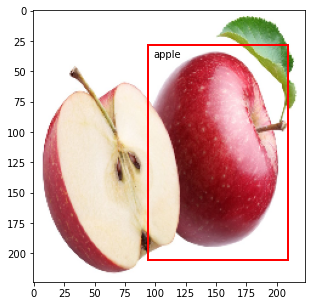

In [12]:
img, target = dataset[25]
plot_box(img, target)

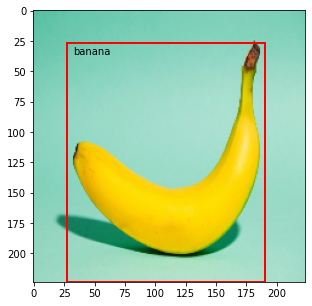

In [13]:
img, target = dataset[75]
plot_box(img, target)

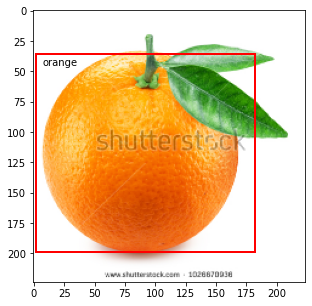

In [14]:
img, target = dataset[175]
plot_box(img, target)

### Создание и получение модели

В качестве модели используется архитектура **Faster R-CNN** 

In [15]:
def get_model(num_classes):
    # Загрузка заранее натренированной модели
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### Применение трансформации

In [16]:
def get_transform(train=True):
    return A.Compose([            
            ToTensorV2(p=0.1), # Используем формат координат pascal_voc 
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))    

## Разделение датасета на train и test

In [41]:
test_split = 0.2

# Создание трейн и тестовых датасетов с реализованными выше трансформациями
dataset_train = FruitDataset(files_dir, 480, 480, transforms=get_transform(train=True))
dataset_test = FruitDataset(files_dir, 480, 480, transforms=get_transform(train=False))

# Фиксация случайного числа
torch.manual_seed(117)
indices = torch.randperm(len(dataset)).tolist()

# Разделение на train и test в соотношении 80% к 20%
tsize = int(len(dataset) * test_split) # Getting the splitting index
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

#Вспомогательная функция, возвращающая кортеж
def collate_fn(batch):
    return tuple(zip(*batch))

# Создание трейн и тестовых даталоадеров
# batch_size используется равным 25, возможно на 16гб памяти на GPU может не поместиться, тогда стоит уменьшить
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=25, shuffle=True, num_workers=0, collate_fn=collate_fn)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=25, shuffle=True, num_workers=0, collate_fn=collate_fn)

## Тренировка модели

In [18]:
# Проверка доступности GPU
torch.cuda.is_available()

True

In [19]:
from torchvision.ops.boxes import box_iou
from torch import tensor
from tqdm.notebook import tqdm
import time

# Определение девайса
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Функция обучения модели
def start_training(num_epochs, num_classes):
    
    # Получение заранее предобученной модели
    model = get_model(num_classes)   
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    len_dataloader = len(dataloader_train)
    
    # Уменьшиени lr на коэффициент 0.2 каждые 10 эпох
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
        
    loss_list = []

    print('Начало тренировки')
    for epoch in range(num_epochs):
        epoch_loss = 0

        loss_sub_list = []
        
        # Фиксация времени для отображения времени обучения каждой эпохи
        start = time.time()

        for images, targets in tqdm(dataloader_train):
            images = list(image.to(device) for image in images)
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            
            model.train()

            #predict
            predict = model(images, targets) 
            losses = sum(loss for loss in predict.values())

            loss_value = losses.item()
            loss_sub_list.append(loss_value)
            
            # Обновление optimizer и lr
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses

        end = time.time()
            
        # Вывод loss'а для каждой эпохи
        epoch_loss = np.mean(loss_sub_list)
        loss_list.append(epoch_loss)

        print(epoch+1, '/', num_epochs, 'Epoch loss: {:.3f} , время: ({:.1f}s)'.format(epoch_loss, end-start))        
    return model

In [42]:
# Служебная информация по использованию GPU и очистка памяти
!nvidia-smi
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

Wed Jul  6 11:03:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:43:00.0  On |                  Off |
|  0%   42C    P8    20W / 382W |  14508MiB / 24564MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
# 3 класса: apple, orange, banana + 1 класс: background
num_classes = 4 
num_epochs = 30

# Запуск функции обучения модели
fast_rcnn = start_training(num_epochs, num_classes)

Начало тренировки


  0%|          | 0/8 [00:00<?, ?it/s]

1 / 30 Epoch loss: 0.817 , время: (67.8s)


  0%|          | 0/8 [00:00<?, ?it/s]

2 / 30 Epoch loss: 0.419 , время: (12.4s)


  0%|          | 0/8 [00:00<?, ?it/s]

3 / 30 Epoch loss: 0.377 , время: (14.8s)


  0%|          | 0/8 [00:00<?, ?it/s]

4 / 30 Epoch loss: 0.349 , время: (12.9s)


  0%|          | 0/8 [00:00<?, ?it/s]

5 / 30 Epoch loss: 0.311 , время: (13.3s)


  0%|          | 0/8 [00:00<?, ?it/s]

6 / 30 Epoch loss: 0.259 , время: (23.3s)


  0%|          | 0/8 [00:00<?, ?it/s]

7 / 30 Epoch loss: 0.207 , время: (14.9s)


  0%|          | 0/8 [00:00<?, ?it/s]

8 / 30 Epoch loss: 0.189 , время: (29.0s)


  0%|          | 0/8 [00:00<?, ?it/s]

9 / 30 Epoch loss: 0.172 , время: (11.7s)


  0%|          | 0/8 [00:00<?, ?it/s]

10 / 30 Epoch loss: 0.156 , время: (13.2s)


  0%|          | 0/8 [00:00<?, ?it/s]

11 / 30 Epoch loss: 0.148 , время: (16.1s)


  0%|          | 0/8 [00:00<?, ?it/s]

12 / 30 Epoch loss: 0.138 , время: (15.0s)


  0%|          | 0/8 [00:00<?, ?it/s]

13 / 30 Epoch loss: 0.129 , время: (15.4s)


  0%|          | 0/8 [00:00<?, ?it/s]

14 / 30 Epoch loss: 0.123 , время: (14.3s)


  0%|          | 0/8 [00:00<?, ?it/s]

15 / 30 Epoch loss: 0.119 , время: (13.0s)


  0%|          | 0/8 [00:00<?, ?it/s]

16 / 30 Epoch loss: 0.112 , время: (12.6s)


  0%|          | 0/8 [00:00<?, ?it/s]

17 / 30 Epoch loss: 0.108 , время: (29.3s)


  0%|          | 0/8 [00:00<?, ?it/s]

18 / 30 Epoch loss: 0.106 , время: (20.7s)


  0%|          | 0/8 [00:00<?, ?it/s]

19 / 30 Epoch loss: 0.098 , время: (58.8s)


  0%|          | 0/8 [00:00<?, ?it/s]

20 / 30 Epoch loss: 0.095 , время: (16.0s)


  0%|          | 0/8 [00:00<?, ?it/s]

21 / 30 Epoch loss: 0.092 , время: (16.2s)


  0%|          | 0/8 [00:00<?, ?it/s]

22 / 30 Epoch loss: 0.087 , время: (28.5s)


  0%|          | 0/8 [00:00<?, ?it/s]

23 / 30 Epoch loss: 0.085 , время: (16.0s)


  0%|          | 0/8 [00:00<?, ?it/s]

24 / 30 Epoch loss: 0.083 , время: (14.5s)


  0%|          | 0/8 [00:00<?, ?it/s]

25 / 30 Epoch loss: 0.084 , время: (15.1s)


  0%|          | 0/8 [00:00<?, ?it/s]

26 / 30 Epoch loss: 0.079 , время: (16.7s)


  0%|          | 0/8 [00:00<?, ?it/s]

27 / 30 Epoch loss: 0.075 , время: (15.7s)


  0%|          | 0/8 [00:00<?, ?it/s]

28 / 30 Epoch loss: 0.072 , время: (12.3s)


  0%|          | 0/8 [00:00<?, ?it/s]

29 / 30 Epoch loss: 0.071 , время: (14.5s)


  0%|          | 0/8 [00:00<?, ?it/s]

30 / 30 Epoch loss: 0.069 , время: (11.6s)


In [44]:
# Сохранение обученной модели для последующих использований
torch.save(fast_rcnn, 'fast_rcnn_model.pt')

In [45]:
# Загрузка модели
device = torch.device('cuda')
fast_rcnn_model = torch.load('./fast_rcnn_model.pt', map_location=device)
fast_rcnn_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [46]:
ls

 Volume in drive D is job
 Volume Serial Number is 6E9A-69B3

 Directory of D:\python-learn\dls_project

07/06/2022  11:12 AM    <DIR>          .
07/06/2022  11:12 AM    <DIR>          ..
02/12/2022  02:02 AM    <DIR>          .ipynb_checkpoints
02/12/2022  02:27 AM    <DIR>          __pycache__
02/12/2022  02:28 AM    <DIR>          data
01/29/2022  05:04 PM        29,720,259 data.zip
07/06/2022  11:13 AM       165,785,193 fast_rcnn_model.pt
07/06/2022  11:12 AM           506,678 my_detection.ipynb
02/12/2022  02:21 AM    <DIR>          vision
               3 File(s)    196,012,130 bytes
               6 Dir(s)  177,663,025,152 bytes free


## Реализация функции NMS или Non-maximum Suppression

Когда модель предсказывает множество различных боксов, тогда надо применять алгоритм Non-maximum Suppression, с помощью которого можно оставить только одну, наилучшую, ограничивающую рамку.

In [47]:
def nms(prediction, threshold):    
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def tensorToPIL(img):
    return transforms.ToPILImage()(img).convert('RGB')

### Специально для задания №2: Запуск детектора на случайных изображениях

    Тестовое изображение


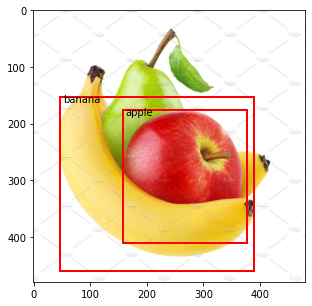

    После обучения и применения nms


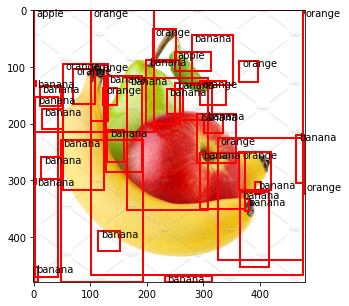

In [48]:
# Получаем предобученную модель fasterrcnn_resnet50_fpn(pretrained=True) из хаба
# помещаем на GPU и переводим в режим предсказания
# Вызываем функцию для отображения боксов на предобученной, но не на тренированной модели по нашему датасету

model = get_model(num_classes)
model.to(device)
model.eval()
show_img(dataset_test[0], model)

По результату видно, что качество оставляет желать лучшего

## Реализация метрики mAP 

In [49]:
# Получение данных для расчета tp, fp и fn
def get_maps(iou_mat, pr_count):
    maps = torch.zeros_like(iou_mat)    
    if not iou_mat[:,0].eq(0.).all():       
        maps[iou_mat[:,0].argsort()[-1],0] = 1

    for pr_idx in range(1,pr_count):
        # С помощью суммы предыдущих значений определяем, какие gt-box'ы заасайнены
        assign_not = torch.logical_not(maps[:,:pr_idx].sum(1)).long()

        # Получение gt-box'а для последующей оценки 
        gtbox = assign_not * iou_mat[:,pr_idx]

        # Если ни один gt-box не удовлетворяет предыдущим условиям для текущего бокса, то игнорируем его
        if gtbox.eq(0).all():
            continue
            
        maps[gtbox.argsort()[-1], pr_idx] = 1
    return maps

# Получение координат
def coordinates(boxes):
    x1_y1 = torch.min(boxes[:,:2,],boxes[:, 2:])
    x2_y2 = torch.max(boxes[:,:2,],boxes[:, 2:])
    return torch.cat([x1_y1,x2_y2], dim=1)

# Функция расчета iou
def calc_iou(gt, pr):
    gt = coordinates(gt)
    pr = coordinates(pr)    
    return box_iou(gt,pr)

# Получение результата mAP
def calc_map(gt_boxes,pr_boxes, scores, thresh=0.5):

    # рассчитываем calc_iou
    iou_mat = calc_iou(gt_boxes,pr_boxes)
    gt_count, pr_count = iou_mat.shape
    
    # пороговое значение
    iou_mat = iou_mat.where(iou_mat>thresh,tensor(0.).to(device))
    gt_count, pr_count = iou_mat.shape
        
    maps = get_maps(iou_mat, pr_count)
    
    # Расчет mAP по формуле tp / (tp+fp+fn)
    tp = maps.sum()
    fp = maps.sum(0).eq(0).sum()
    fn = maps.sum(1).eq(0).sum()
    mAP = tp / (tp+fp+fn)
    
    return mAP

In [50]:
# Функция расчета метрики обученной модели на нашем датасете
def score_model(model, data):
    model.eval()      
    X_preds, Y_label, scores = [], [], []

    for X, Y in data:
        model.eval()
        with torch.no_grad():
            prediction = model([X.to(device)])[0]
            # Применяем функцию nms для получения только одной, наиболее лучшей рамки
            prediction = nms(prediction, threshold=0.3)
      
        X_preds.append(prediction['boxes'])
        Y_label.append(Y['boxes'])
        scores.append(prediction['scores'])

    X_preds = torch.cat(X_preds).to(device).float()
    Y_label = torch.cat((Y_label)).to(device).float()
    scores = torch.cat((scores)).to(device)

    return calc_map(Y_label, X_preds, scores, thresh=0.5)

score = score_model(fast_rcnn, dataset_test)
score

tensor(0.6434, device='cuda:0')

## Тестирование результатов обучение модели по архитектуре Fast R-CNN

In [51]:
# Поулчение изображение из тестового набора
img, target = dataset_test[5]

# Перевод модели в режим предсказания
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]    

Тестовое изображение


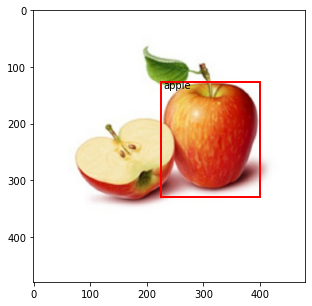

In [52]:
print('Тестовое изображение')
plot_box(tensorToPIL(img), target)

После обучения


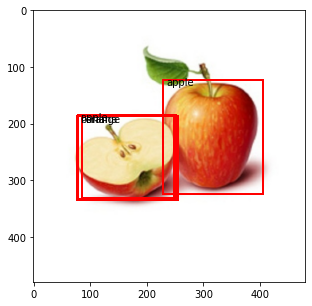

In [53]:
print('После обучения')
plot_box(tensorToPIL(img), prediction)

После обучения видно, что присутствует несколько боксов, вместо одного. Чтобы это убрать, нужно применить заранее реализованную функцию с алгоритмом Non-maximum Suppression.

### Применение фунции NMS

Изображение после обучения и применения nms


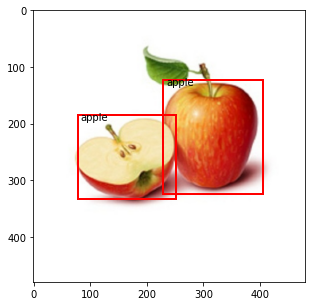

In [54]:
nms_pred = nms(prediction, threshold=0.2)
print('Изображение после обучения и применения nms')
plot_box(tensorToPIL(img), nms_pred)

    Тестовое изображение


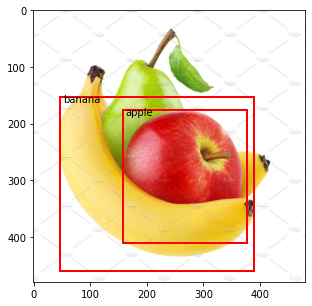

    После обучения и применения nms


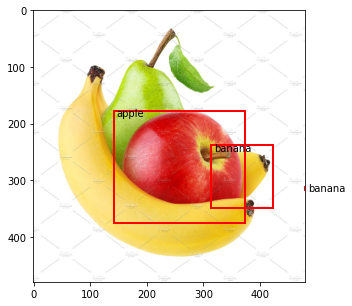

In [55]:
show_img(dataset_test[0], fast_rcnn)

    Тестовое изображение


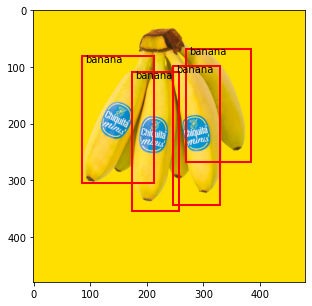

    После обучения и применения nms


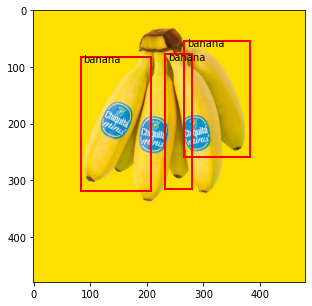

In [56]:
show_img(dataset_test[7], fast_rcnn)

    Тестовое изображение


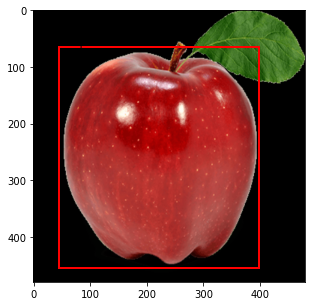

    После обучения и применения nms


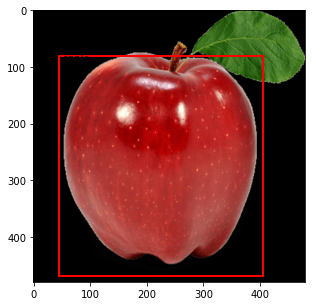

In [57]:
show_img(dataset_test[9], fast_rcnn)

    Тестовое изображение


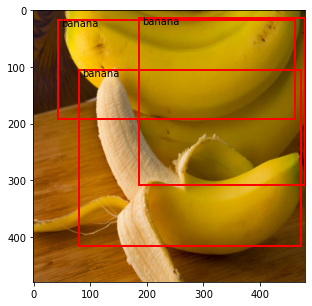

    После обучения и применения nms


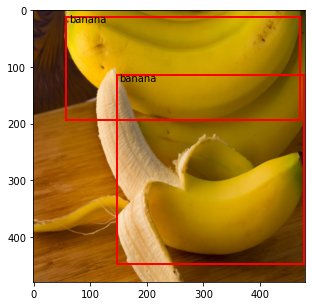

In [58]:
show_img(dataset_test[20], fast_rcnn)

    Тестовое изображение


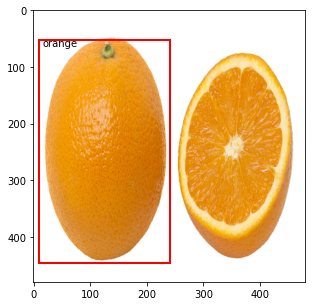

    После обучения и применения nms


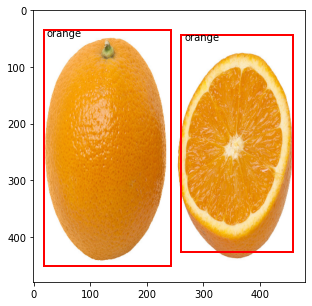

In [59]:
show_img(dataset_test[41], fast_rcnn)

    Тестовое изображение


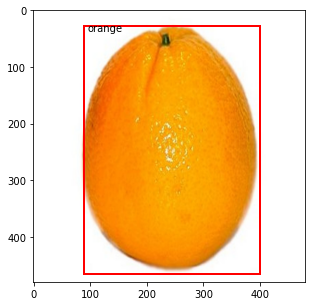

    После обучения и применения nms


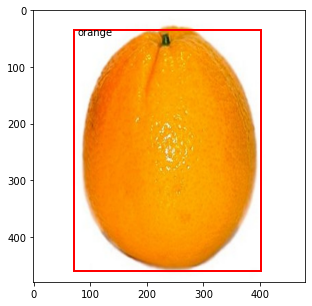

In [60]:
show_img(dataset_test[40], fast_rcnn)

    Тестовое изображение


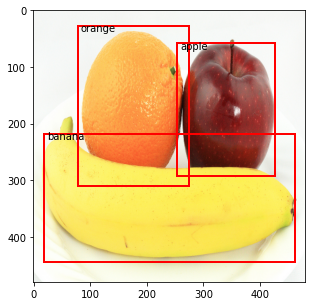

    После обучения и применения nms


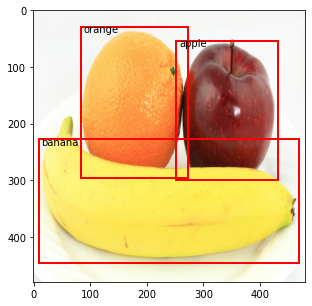

In [61]:
show_img(dataset_test[-1], fast_rcnn)

## Архитектура нашей модели

In [62]:
fast_rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Задачи

1) **Выбор фреймворка/библиотеки для использования детектора** <br>
В качестве фреймворка/библиотеки был выбран torchvision и torchvision.models.detection, а в качестве модели faster_rcnn
<br><br>
2) **Запуск детектора на случайных изображениях**<br>
Выше в ноутбуке описан запуск детектора на случайном изображении.
<br><br>
3) **Выбор датасета**<br>
В качестве датасета используется "Детекция фруктов"
https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection
<br><br>
4) **Предобработка данных**<br>
Рализована обработка данных и сформирован **FruitDataset**
<br><br>
5) **Обучение модели-детектора**
Реализован собственный цикл обучения, функция **start_training**, реализован вывод loss
<br><br>
6) **Измерение качества работы модели**<br>
Реализована метрика mAP, как одна из наиболее распространенных. <br><br>
Скор при **threshold=0.25** получился равным **mAP=0.7101**<br>
Скор при **threshold=0.40** получился равным **mAP=0.6978**<br>
Скор при **threshold=0.50** получился равным **mAP=0.6190**<br>